<a target="_blank" href="https://colab.research.google.com/github/piavik/Prognosis/blob/dev/experiments/EDA_RandForest.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Прогнозування Відтоку Клієнтів для Телекомунікаційної компанії

# Вступ
ви влаштувались на першу роботу в IT на позицію Data Scientist. Ваш керівник вирішив дати вам невеличкий проєкт, щоб ви ознайомились з базою даних клієнтів, видами сервісів, які надає компанія і технічними можливостями компанії.
Цей документ описує технічне завдання проєкту, метою якого є розробка прогностичної моделі для ідентифікації ймовірності припинення клієнтами користування телекомунікаційними послугами на основі історичних даних про клієнтів. Проєкт передбачає використання аналізу даних, перед обробки даних, машинного навчання, оцінки моделей, а також пакування моделі у контейнер для забезпечення відтворюваності.

## Опис Даних
Надається набір даних, який включає інформацію про клієнтів телекомунікаційної компанії: демографічні характеристики, історію використання послуг, тарифні плани, дані про відток(Churn).

## Завантаження і ініціалізація

In [62]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc

from imblearn.over_sampling import SMOTE

%matplotlib inline



time: 4.83 ms (started: 2024-10-18 19:10:26 +00:00)


In [63]:
import warnings
warnings.filterwarnings('ignore')

time: 705 µs (started: 2024-10-18 19:10:27 +00:00)


In [64]:
GDRIVE_URL='https://drive.usercontent.google.com/u/0/uc?id='
FILE_ID='121xd_NVxBIiDevkqnNUDpDdwj8jcR41D'
CSV_DATA_PATH  = Path('./').absolute()
CSV_DATA_PATH.mkdir(exist_ok=True)
# FILENAME = "internet_service_churn.csv"
FILENAME = "processed_dataset.csv"
zipfilename = "archive.zip"

PROJECT_NAME = "Prognosis"

SEED = 42
TEST_SIZE = 0.2

time: 1.46 ms (started: 2024-10-18 19:10:27 +00:00)


In [65]:
# встановлення модуля для вимірюання часу виконання тільки в Colab середовищі
# завантеження файлу з даними і розархівування
# підготовка папки для зберігання
if os.getenv("COLAB_RELEASE_TAG") == None:
  print('it is not colab')
  import shutil
  import requests
  from zipfile import ZipFile
  file_url = f"{GDRIVE_URL}{FILE_ID}"
  req = requests.get(file_url, allow_redirects=True, stream=True)
  with open(zipfilename, 'wb') as fd:
    for chunk in req.iter_content(chunk_size=128):
      fd.write(chunk)
  with ZipFile(zipfilename, 'r') as zip_file:
       zip_file.extractall(CSV_DATA_PATH)
  os.remove(zipfilename)
  MODELS_PATH = Path(f'./{PROJECT_NAME}').absolute()
  MODELS_PATH.mkdir(exist_ok=True)

else:
  print('it is colab environment, proceeding with install ...')
  !pip install -q ipython-autotime
  # !gdown $FILE_ID
  # !unzip -oq $zipfilename -d $CSV_DATA_PATH

  from google.colab import drive
  drive.mount('/content/gdrive')

  MODELS_PATH = Path(f'/content/gdrive/MyDrive/Colab Notebooks/{PROJECT_NAME}').absolute()
  MODELS_PATH.mkdir(exist_ok=True)

  %load_ext autotime

it is colab environment, proceeding with install ...
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 6.46 s (started: 2024-10-18 19:10:27 +00:00)


In [66]:
# створення датасету з файлу
df = pd.read_csv(MODELS_PATH/FILENAME)

time: 68.4 ms (started: 2024-10-18 19:10:33 +00:00)


In [67]:
df.head()

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,download_avg,upload_avg,churn
0,1,0,11.95,25,0.14,8.4,2.3,0
1,0,0,8.22,0,0.00,0.0,0.0,1
2,1,0,8.91,16,0.00,13.7,0.9,1
3,0,0,6.87,21,0.00,0.0,0.0,1
4,0,0,6.39,0,0.00,0.0,0.0,1


time: 44.4 ms (started: 2024-10-18 19:10:33 +00:00)


# Моделювання




In [68]:
X = df.drop(columns=["churn"])
y = df["churn"]

time: 3.18 ms (started: 2024-10-18 19:10:33 +00:00)


In [69]:
# # test
# X = df[['reamining_contract', 'is_tv_subscriber']]
# y = df["churn"]

# # test results on the best model: 0.9237777314138674

time: 364 µs (started: 2024-10-18 19:10:33 +00:00)


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SIZE,
                                                    random_state=SEED,
                                                    shuffle=True,
                                                    stratify=y
                                                    )

time: 28.5 ms (started: 2024-10-18 19:10:33 +00:00)


In [71]:
print(y_train.value_counts())

churn
1    32040
0    25465
Name: count, dtype: int64
time: 5.06 ms (started: 2024-10-18 19:10:33 +00:00)


## RandomForest

In [72]:
def RF_grid_search(X_train, y_train):
  # Створення класифікатора Random Forest
  model = RandomForestClassifier(n_jobs=-1, random_state=SEED)

  # Визначення сітки гіперпараметрів для перебору
  param_grid = {
      'n_estimators': [50, 100, 200, 300],
      # 'criterion': ['gini', 'entropy', 'log_loss'],
      'max_features': ['sqrt', 'log2'],
      'max_depth': [None, 5, 10],
      'min_samples_leaf': [1, 2]
  }

  # Створення об'єкта GridSearchCV
  gridsearch = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            cv=3,
                            scoring='accuracy'
                            )

  gridsearch.fit(X_train, y_train)

  return gridsearch

time: 685 µs (started: 2024-10-18 19:10:33 +00:00)


In [73]:
def show_gridsearch_results(name, gridsearch):

  # Оцінка точності моделі з найкращими параметрами
  best_model = gridsearch.best_estimator_
  y_pred = best_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)

  plt.figure(figsize=(18, 6))
  # Матриця плутанини
  plt.subplot(1, 3, 1)
  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16})
  plt.title(f'Confusion Matrix - {name}')

  # PR-крива
  plt.subplot(1, 3, 2)
  precision, recall, _ = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:, 1])
  plt.plot(recall, precision, color='b', label='PR Curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title(f'Precision-Recall Curve - {name}')
  plt.legend()

  # ROC-крива
  plt.subplot(1, 3, 3)
  fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color='r', label=f'ROC Curve (AUC = {roc_auc:.4f})')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve - {name}')
  plt.legend()

  plt.tight_layout()
  plt.show()

  # Вивід найкращих знайдених гіперпараметрів
  print("\nНайкращі параметри:", gridsearch.best_params_, "\n\n")

  # Точність найкращої моделі
  print(f"Точність моделі з найкращими параметрами: {accuracy}\n\n")

  print(classification_report(y_test, y_pred))

time: 1.16 ms (started: 2024-10-18 19:10:33 +00:00)


### Classic

In [74]:
classic_RF_gridsearch = RF_grid_search(X_train, y_train)

time: 12min 37s (started: 2024-10-18 19:10:33 +00:00)


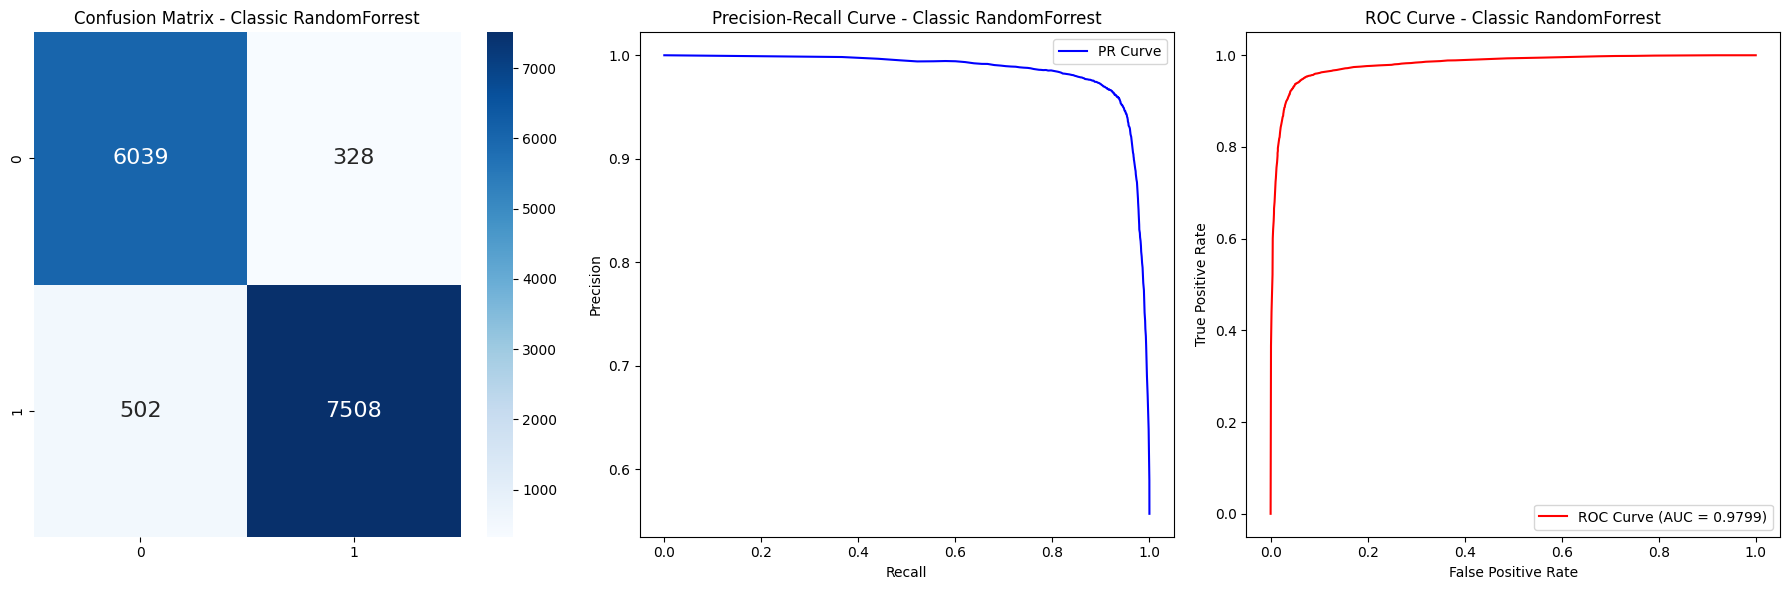


Найкращі параметри: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300} 


Точність моделі з найкращими параметрами: 0.9422689017180218


              precision    recall  f1-score   support

           0       0.92      0.95      0.94      6367
           1       0.96      0.94      0.95      8010

    accuracy                           0.94     14377
   macro avg       0.94      0.94      0.94     14377
weighted avg       0.94      0.94      0.94     14377

time: 3.98 s (started: 2024-10-18 19:23:11 +00:00)


In [75]:
show_gridsearch_results("Classic RandomForrest", classic_RF_gridsearch)

Висновок:

найкращі параметри показала модель у якої майже всі гіперпараметри за замовчанням

Подальше збільшення кількості естиматорів незначно покращує модель.


### Scaling

In [76]:
# Scaling
# scaler = StandardScaler()
scaler = MinMaxScaler()
# x_scaled = scaler.fit_transform(X_train) ### <-- неправильно

time: 826 µs (started: 2024-10-18 19:23:15 +00:00)


In [77]:
# скейлити треба тільки небінарні дані
# columns_to_scale = ['subscription_age', 'bill_avg', 'reamining_contract', 'service_failure_count', 'download_avg', 'upload_avg', 'download_over_limit']
columns_to_scale = ['subscription_age', 'bill_avg', 'reamining_contract', 'download_avg', 'upload_avg']
x_scaled = scaler.fit_transform(X_train[columns_to_scale])

time: 11.4 ms (started: 2024-10-18 19:23:15 +00:00)


In [78]:
x_scaled.shape

(57505, 5)

time: 4.73 ms (started: 2024-10-18 19:23:15 +00:00)


In [79]:
df_scaled = X_train[:]
df_scaled[columns_to_scale] = x_scaled
df_scaled

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,download_avg,upload_avg
42682,1,0,0.033541,0.038596,0.000000,0.002516,0.004412
41658,1,1,0.239470,0.084211,0.301370,0.003459,0.001324
41407,1,0,0.241030,0.042105,0.297945,0.028901,0.041915
33242,1,1,0.368955,0.056140,0.404110,0.031165,0.020075
9689,1,1,0.553042,0.059649,0.376712,0.036700,0.007280
...,...,...,...,...,...,...,...
25743,1,0,0.011700,0.000000,0.000000,0.000000,0.000000
13406,1,1,0.170047,0.000000,0.000000,0.001101,0.000441
62975,1,1,0.028081,0.003509,0.000000,0.005787,0.002647
2562,1,1,0.665367,0.042105,0.613014,0.006290,0.002206


time: 71.4 ms (started: 2024-10-18 19:23:15 +00:00)


In [80]:
scaled_RF_gridsearch = RF_grid_search(df_scaled, y_train)

time: 12min 57s (started: 2024-10-18 19:23:15 +00:00)


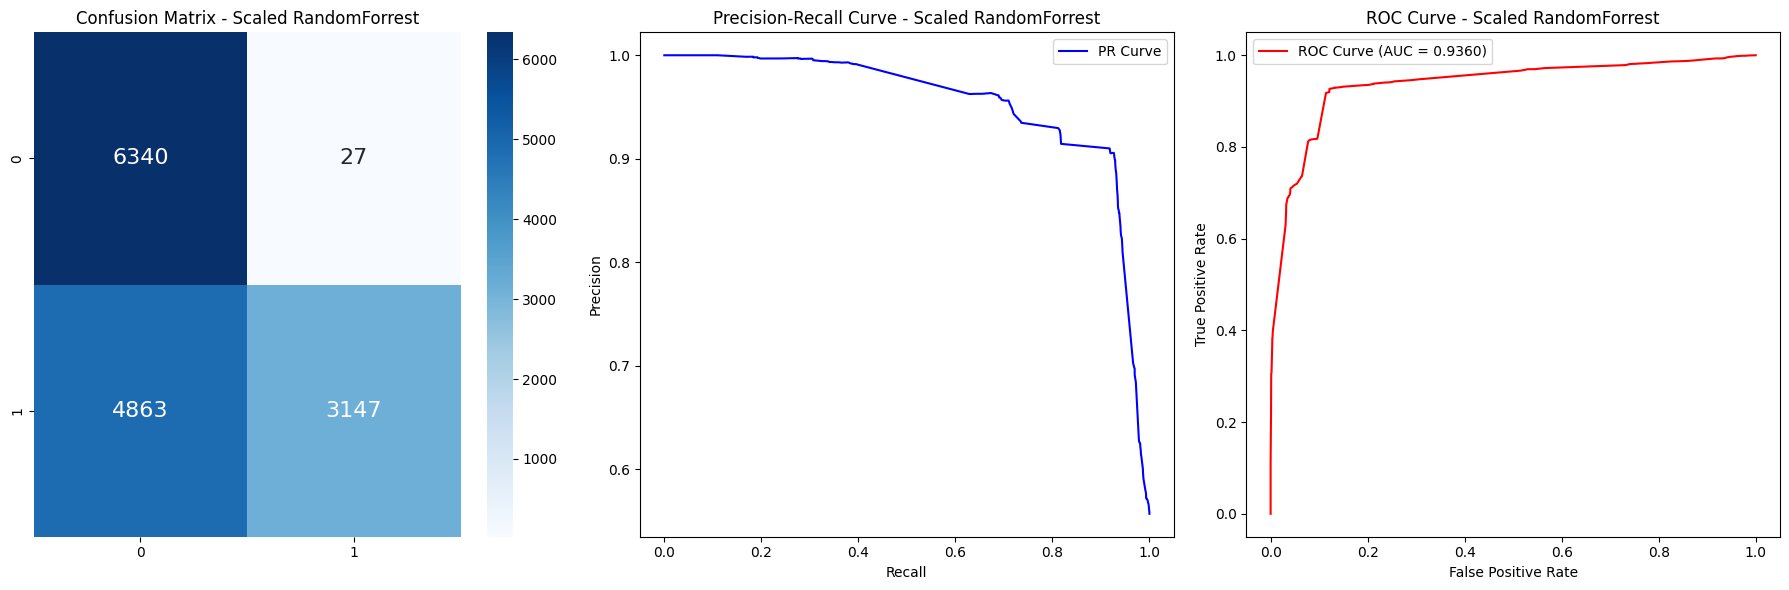


Найкращі параметри: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300} 


Точність моделі з найкращими параметрами: 0.6598734089170203


              precision    recall  f1-score   support

           0       0.57      1.00      0.72      6367
           1       0.99      0.39      0.56      8010

    accuracy                           0.66     14377
   macro avg       0.78      0.69      0.64     14377
weighted avg       0.80      0.66      0.63     14377

time: 1.91 s (started: 2024-10-18 19:36:13 +00:00)


In [81]:
show_gridsearch_results("Scaled RandomForrest", scaled_RF_gridsearch)

Висновок:

При використанні скейлінгу на числових параметрах різко виростає кількисть помилкових передбачень False Positives

Загальний результат точності набагато гірший ніж без скейлінгу

### Oversampled

In [82]:
oversampler = SMOTE(random_state=SEED)
x_resample, y_resample = oversampler.fit_resample(X_train, y_train)

time: 670 ms (started: 2024-10-18 19:36:15 +00:00)


In [83]:
oversampled_RF_gridsearch = RF_grid_search(x_resample, y_resample)

time: 14min 38s (started: 2024-10-18 19:36:16 +00:00)


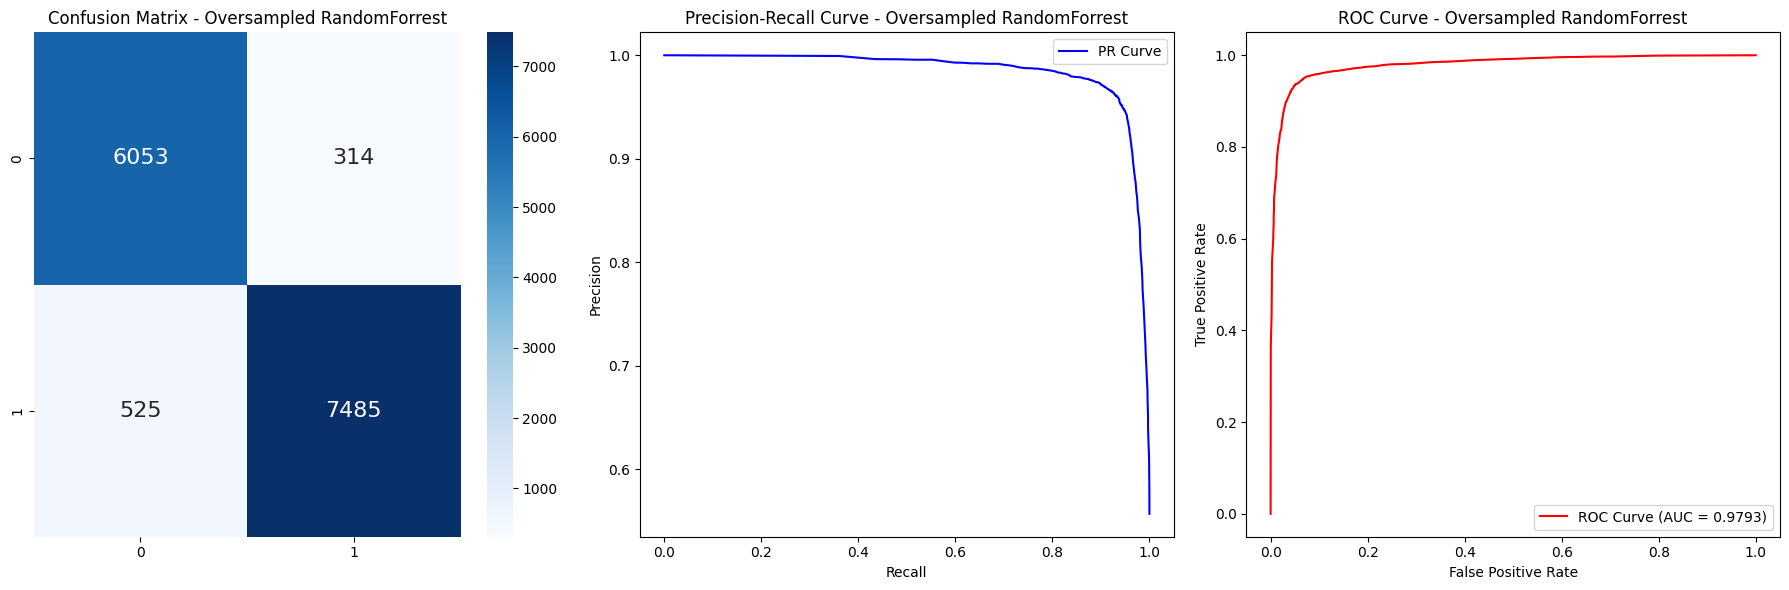


Найкращі параметри: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300} 


Точність моделі з найкращими параметрами: 0.941642901857133


              precision    recall  f1-score   support

           0       0.92      0.95      0.94      6367
           1       0.96      0.93      0.95      8010

    accuracy                           0.94     14377
   macro avg       0.94      0.94      0.94     14377
weighted avg       0.94      0.94      0.94     14377

time: 2.52 s (started: 2024-10-18 19:50:54 +00:00)


In [84]:
show_gridsearch_results("Oversampled RandomForrest", oversampled_RF_gridsearch)

Висновок:

найкращою вибрана модель з дефолтними гіперпараметрами

oversampling практично не впливає на точність прогнозу

в порівнянні з класичним RF спостерігаєтсья погіршення accuracy на долі відсотка

# Save best model

In [85]:
joblib.dump(classic_RF_gridsearch, f"{MODELS_PATH}/classic_RF_gridsearch.bin")

['/content/gdrive/MyDrive/Colab Notebooks/Prognosis/classic_RF_gridsearch.bin']

time: 1.38 s (started: 2024-10-18 19:50:57 +00:00)


In [86]:
joblib.dump(classic_RF_gridsearch.best_estimator_, f"{MODELS_PATH}/random_forest_model.pkl"б com=3)

['/content/gdrive/MyDrive/Colab Notebooks/Prognosis/random_forest_model.pkl']

time: 4.99 s (started: 2024-10-18 19:50:58 +00:00)


# Load saved model

In [87]:
new_model = joblib.load(f"{MODELS_PATH}/random_forest_model.pkl")

time: 1.52 s (started: 2024-10-18 19:51:03 +00:00)


In [88]:
new_model


RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

time: 7.42 ms (started: 2024-10-18 19:51:05 +00:00)


In [89]:
new_model.n_features_in_


7

time: 6.46 ms (started: 2024-10-18 19:51:05 +00:00)


In [90]:
new_model.feature_names_in_

array(['is_tv_subscriber', 'is_movie_package_subscriber',
       'subscription_age', 'bill_avg', 'reamining_contract',
       'download_avg', 'upload_avg'], dtype=object)

time: 4.24 ms (started: 2024-10-18 19:51:05 +00:00)


In [91]:
new_model.classes_

array([0, 1])

time: 5.39 ms (started: 2024-10-18 19:51:05 +00:00)
